At highest frequency 1000 Hz of the plots, w= 0.743929140370063
For Setup1: If every number in the following array < 1, the approximation will be ok: [0.08625132696776688, 0.14172539218499872, 0.03857276604989751, 0.07469584026420395]
For Setup2: If every number in the following array < 1, the approximation will be ok: [0.12937699045165033, 0.23620898697499787, 0.03857276604989751, 0.4481750415852237]
For Setup3: If every number in the following array < 1, the approximation will be ok: [0.12937699045165033, 0.23620898697499787, 0.03857276604989751, 0.8963500831704474]


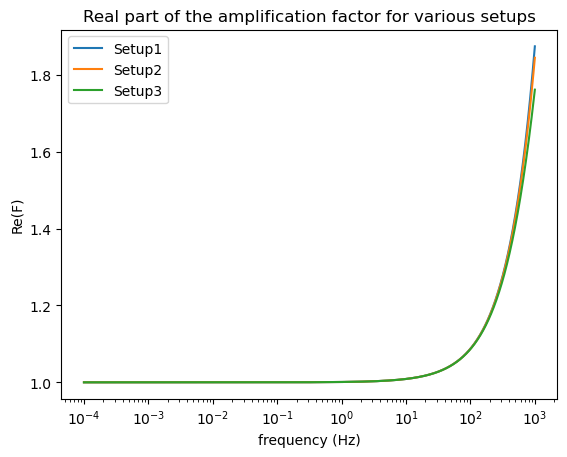

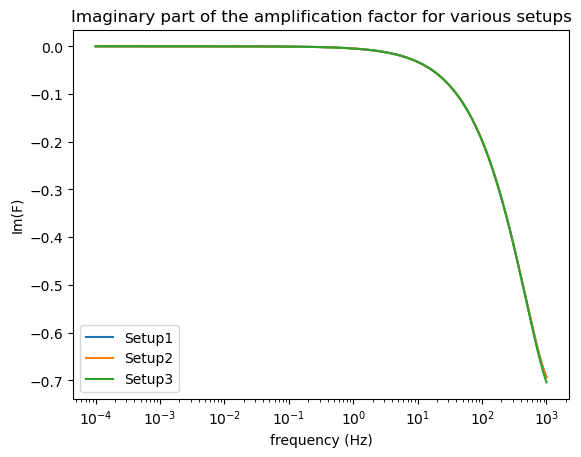

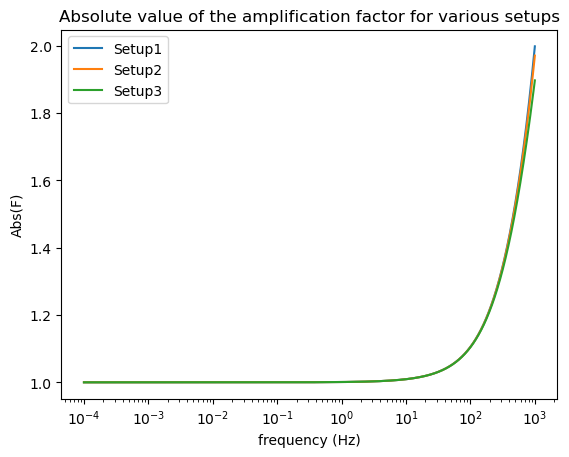

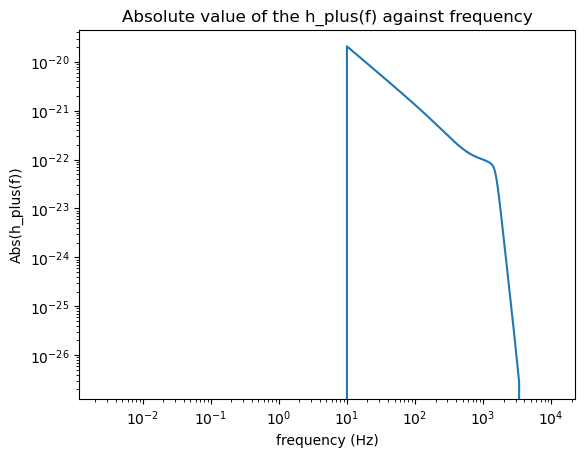

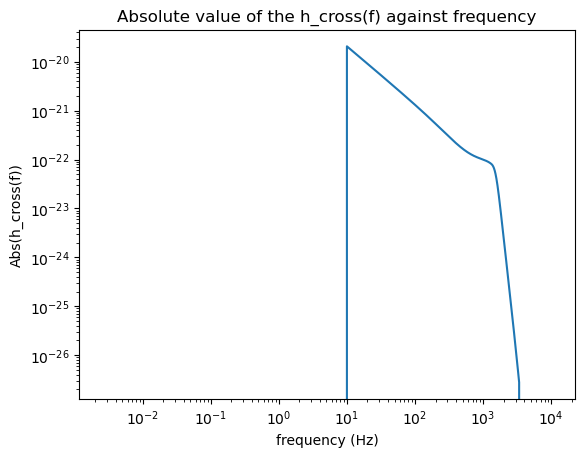

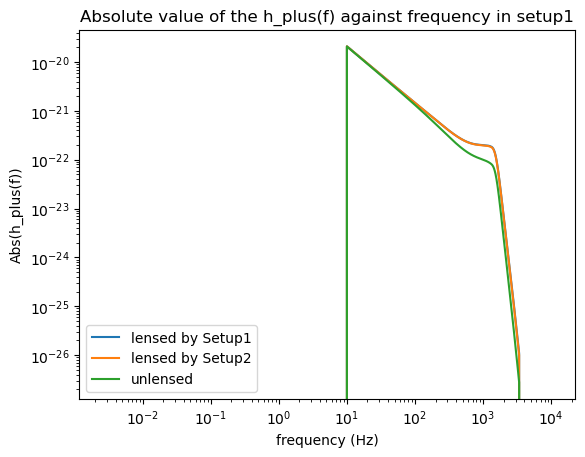

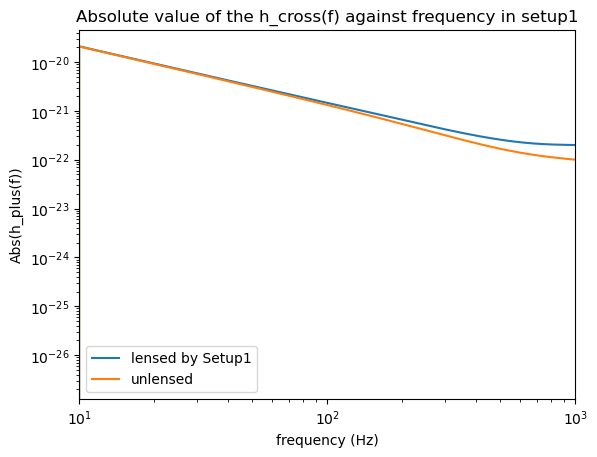

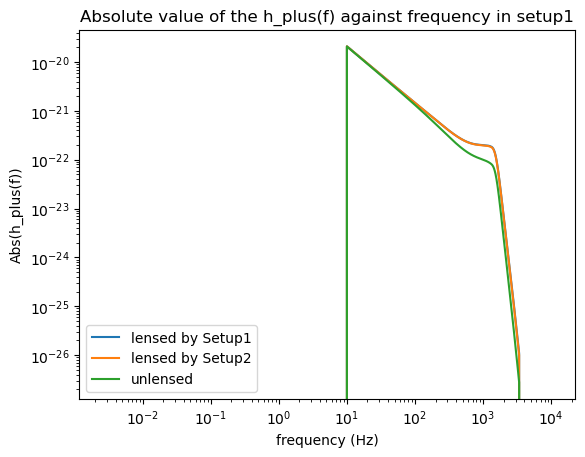

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[7]:


#we fix the number of PML and mass of each of them, but their location are free to move around

import numpy as np
import scipy.special as sc
from matplotlib import pyplot as plt
from astropy.cosmology import Planck18

from pycbc.waveform import td_approximants, fd_approximants
from pycbc import types, fft, waveform

#setting up geometrized units
meter = 1
Mpc = 3.086e22*meter
solarmass = 1480*meter
Hz = 1/(3 * 10**8)

zL = 0.5
zS = 1

#some angular diameter distances
DS = Planck18.angular_diameter_distance(zS).value*Mpc
DL = Planck18.angular_diameter_distance(zL).value*Mpc
DLS = Planck18.angular_diameter_distance_z1z2(zL, zS).value*Mpc



#eta: source position
eta=[0,0]

#N: number of point masses in the lens system
N = 4

#mass of each point mass
mj = np.array([1*solarmass, 1.2*solarmass, 0.8*solarmass, 3*solarmass])

total_mass=np.sum(mj)

#einstein radius of each point mass
xi_0j = 2*np.sqrt(mj*DL*DLS/DS)

def omega(f):
    return 2*np.pi*f

#dimensionless frequency function for each point mass
def wj(f, xi_0, zL, DS, DL, DLS):
    return (1+zL)*omega(f)*xi_0**2 *DS/(DL*DLS)

def first_order_F(f, xi_0, zL, DS, DL, DLS, Y):
    return 0.5*wj(f, xi_0, zL, DS, DL, DLS)*(np.pi-1j*(2*np.log(Y)-sc.expi(1j*wj(f, xi_0, zL, DS, DL, DLS)*Y**2 /2)))

def F(f, xi_0j, zL, DS, DL, DLS, Yj):
    #somehow using np.sum would not work!!!
    return 1 + sum([first_order_F(f, xi_0j[j], zL, DS, DL, DLS, Yj[j]) for j in range(N)])

#to edit the position of the pml, please modify jth_lens_pos_setup(n)=[[x1,y1],[x2,y2],...]
#Setup1
jth_lens_pos_setup1=[[0.2*xi_0j[0],0],[-0.3*xi_0j[1],0],[0*xi_0j[2],-0.1*xi_0j[2]],[0*xi_0j[3],0.1*xi_0j[3]]]
Yjsetup1 = [np.sqrt((jth_lens_pos_setup1[j][0]-eta[0]*DL/DS)**2+(jth_lens_pos_setup1[j][1]-eta[1]*DL/DS)**2)/xi_0j[j] for j in range(N)]


#Setup2
jth_lens_pos_setup2=[[0.3*xi_0j[0],0],[-0.5*xi_0j[1],0],[0*xi_0j[2],-0.1*xi_0j[2]],[0*xi_0j[3],0.6*xi_0j[3]]]
Yjsetup2 = [np.sqrt((jth_lens_pos_setup2[j][0]-eta[0]*DL/DS)**2+(jth_lens_pos_setup2[j][1]-eta[1]*DL/DS)**2)/xi_0j[j] for j in range(N)]


#Setup3
jth_lens_pos_setup3=[[0.3*xi_0j[0],0],[-0.5*xi_0j[1],0],[0*xi_0j[2],-0.1*xi_0j[2]],[0*xi_0j[3],1.2*xi_0j[3]]]
Yjsetup3 = [np.sqrt((jth_lens_pos_setup3[j][0]-eta[0]*DL/DS)**2+(jth_lens_pos_setup3[j][1]-eta[1]*DL/DS)**2)/xi_0j[j] for j in range(N)]

#low and high limit of frequency of the graphs (in Hz)
plot_low_limit=1e-4
plot_high_limit=1000

#As long as w<<1, it's okay
print('At highest frequency', plot_high_limit, 'Hz of the plots, w=',8*np.pi*plot_high_limit*Hz*total_mass)

#check if Yj*sqrt(wj)<1 is satisfied
condition_parameter1=[Yjsetup1[j]*np.sqrt(wj(plot_high_limit*Hz, xi_0j[j], zL, DS, DL, DLS)) for j in range(N)]
print('For Setup1: If every number in the following array < 1, the approximation will be ok:',condition_parameter1)
condition_parameter2=[Yjsetup2[j]*np.sqrt(wj(plot_high_limit*Hz, xi_0j[j], zL, DS, DL, DLS)) for j in range(N)]
print('For Setup2: If every number in the following array < 1, the approximation will be ok:',condition_parameter2)
condition_parameter3=[Yjsetup3[j]*np.sqrt(wj(plot_high_limit*Hz, xi_0j[j], zL, DS, DL, DLS)) for j in range(N)]
print('For Setup3: If every number in the following array < 1, the approximation will be ok:',condition_parameter3)


x = np.logspace(np.log10(plot_low_limit), np.log10(plot_high_limit), 10000)

plt.plot(x, np.real(F(x*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup1)))
plt.plot(x, np.real(F(x*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup2)))
plt.plot(x, np.real(F(x*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup3)))
plt.xscale("log")
plt.title("Real part of the amplification factor for various setups")
plt.xlabel("frequency (Hz)")
plt.ylabel("Re(F)")
plt.legend(["Setup1", "Setup2", "Setup3"], loc ="upper left")

plt.show()


plt.plot(x, np.imag(F(x*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup1)))
plt.plot(x, np.imag(F(x*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup2)))
plt.plot(x, np.imag(F(x*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup3)))
plt.xscale("log")
plt.title("Imaginary part of the amplification factor for various setups")
plt.xlabel("frequency (Hz)")
plt.ylabel("Im(F)")
plt.legend(["Setup1", "Setup2", "Setup3"], loc ="lower left")

plt.show()

plt.plot(x, np.absolute(F(x*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup1)))
plt.plot(x, np.absolute(F(x*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup2)))
plt.plot(x, np.absolute(F(x*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup3)))
plt.xscale("log")
plt.title("Absolute value of the amplification factor for various setups")
plt.xlabel("frequency (Hz)")
plt.ylabel("Abs(F)")
plt.legend(["Setup1", "Setup2", "Setup3"], loc ="upper left")

plt.show()


#print(fd_approximants())


# Get a frequency domain waveform
#sp: plus phase, sc:cross phase
sptilde, sctilde = waveform. get_fd_waveform(approximant="IMRPhenomPv2",
                             mass1=6, mass2=6, delta_f=1.0/400, f_lower=10,f_final=10000)

plt.plot(sptilde.sample_frequencies, np.abs(sptilde))
plt.xscale("log")
plt.yscale("log")
plt.title("Absolute value of the h_plus(f) against frequency")
plt.xlabel("frequency (Hz)")
plt.ylabel("Abs(h_plus(f))")

plt.show()


plt.plot(sctilde.sample_frequencies, np.abs(sctilde))
plt.xscale("log")
plt.yscale("log")
plt.title("Absolute value of the h_cross(f) against frequency")
plt.xlabel("frequency (Hz)")
plt.ylabel("Abs(h_cross(f))")

plt.show()


plt.plot(sptilde.sample_frequencies, np.abs(sptilde * F(sptilde.sample_frequencies*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup1)))
plt.plot(sptilde.sample_frequencies, np.abs(sptilde * F(sptilde.sample_frequencies*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup2)))
plt.plot(sptilde.sample_frequencies, np.abs(sptilde))
plt.xscale("log")
plt.yscale("log")
plt.title("Absolute value of the h_plus(f) against frequency in setup1")
plt.xlabel("frequency (Hz)")
plt.ylabel("Abs(h_plus(f))")
plt.legend(["lensed by Setup1", "lensed by Setup2", "unlensed"], loc ="lower left")


plt.show()


plt.plot(sctilde.sample_frequencies, np.abs(sctilde * F(sctilde.sample_frequencies*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup1)))
plt.plot(sctilde.sample_frequencies, np.abs(sctilde))
plt.xscale("log")
plt.yscale("log")
plt.title("Absolute value of the h_cross(f) against frequency in setup1")
plt.xlabel("frequency (Hz)")
plt.ylabel("Abs(h_plus(f))")
plt.legend(["lensed by Setup1", "unlensed"], loc ="lower left")
plt.xlim([10,1000])

plt.show()


# In[ ]:


plt.plot(sptilde.sample_frequencies, np.abs(sptilde * F(sptilde.sample_frequencies*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup1)))
plt.plot(sptilde.sample_frequencies, np.abs(sptilde * F(sptilde.sample_frequencies*Hz, xi_0j, zL, DS, DL, DLS, Yjsetup2)))
plt.plot(sptilde.sample_frequencies, np.abs(sptilde))
plt.xscale("log")
plt.yscale("log")
plt.title("Absolute value of the h_plus(f) against frequency in setup1")
plt.xlabel("frequency (Hz)")
plt.ylabel("Abs(h_plus(f))")
plt.legend(["lensed by Setup1", "lensed by Setup2", "unlensed"], loc ="lower left")

